# Unsupervised Clustering of Pet Photos

### What am i doing in this notebook?

In this notebook, I will explore how I can give the computer a group of pet images, and it can cluster the ones with the same animals together.

I will be doing that by encoding the images through a trained convolutional network, and then apply a clustering algorithm to the encoded features. We can then check the clusters and see if it worked!

### Let's import the libraries we'll need

Keras is using a TensorFlow backend in our case here.

In [12]:
%matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

## Dataset information

Pet images are in directories with the following format:

Character + Number + '-' + breed name.

Character is either C or D for cat or dog. Number is a serial number for the breed. No two breeds of the same animal have the same number.

Examples: 

C1-Abyssinian
D6-Chiuahua

We will use this information to list the breeds available and count the number of images available for each.

In [13]:
# directory where images are stored
DIR = "./animal_images"

def dataset_stats():
    
    # This is an array with the letters available.
    # If you add another animal later, you will need to structure its images in the same way
    # and add its letter to this array
    animal_characters = ['C', 'D']
    
    # dictionary where we will store the stats
    stats = []
    
    for animal in animal_characters:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, animal)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [14]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
C1,C1-Abyssinian,198
C12,C12-Sphynx,200
C7,C7-Maine_coon,200
C8,C8-Persian,200
D1,D1-American_bulldog,200
D11,D11-Havanese,200
D21,D21-Scottish_terrier,199
D25,D25-Yorkshire_terrier,200
D9,D9-German_shorthaired,200


### Loading the images

Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.

Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [15]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

#### Now we chose our codes for the breeds that we want and load the images and labels

I will chose two cat breeds and two dog breeds. While working on the whole dataset would yield more interesting results, it requires more memory than my computer has.

In [16]:
codes = ["C1", "C12", "D21", "D25"]
images, labels = load_images(codes)

### Photo time!

Let's have a look at the breeds we loaded! The photos will not be in their original aspect ratio since we've resized them to fit what VGG needs

In [17]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code D25


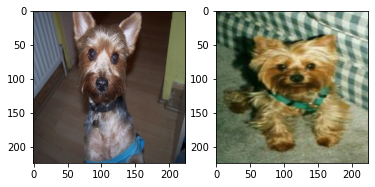

2 random images for code D21


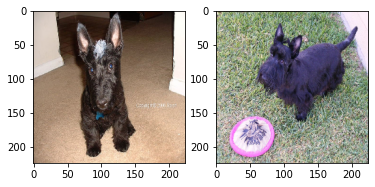

2 random images for code C12


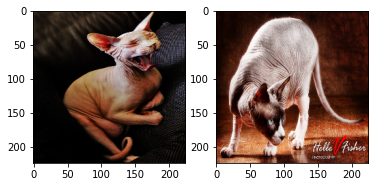

2 random images for code C1


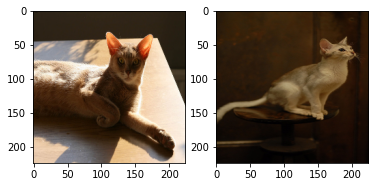

In [18]:
show_random_images(images, labels)

### Normalise...

We now convert the images and labels to NumPy arrays to make processing them easier. We then normaise the images before passing them on to VGG19

In [19]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [20]:
images, labels = normalise_images(images, labels)

### Time to mix it up!

Now that we have all the photos and their labels in arrays. It's time to shuffle them around, and split them to three different sets... training, validation and testing.

We'll be using the `train_test_split` function from sklearn which will also shuffle the data around for us, since it's currently in order.

In [23]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=1, random_state=728)
    
    return X_train, y_train

In [24]:
X_train, y_train = shuffle_data(images, labels)

### Load pre-trained covnet models
#### VGG16, VG19, ResNet50

We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [25]:
# Load the models with ImageNet weights

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))




94773248/94765736 [==============================] - 42s 0us/step


### Output... falls flat

The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.

In [26]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat


In [ ]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features


The above cell shows us the number of features each covnet gives to a single image. When we compare these to the original size of the image 224 x 224 x 3 = 150,528 pixels/features, we can see that this is a large reduction in what the clustering algorithms will have to work with.

 

Hopefully these reduces number of feature are represent more meaningful features in the image structure.

### PCA

While k-means clustering has coped with these numbers, Gaussian Mixture Modelling has not and the computer consistently ran out of memory and struggled to produce results. 

We therefore look to PCA for dimensionality reduction, so that our clustering algorithms can cope.

In [15]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [16]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


In [17]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

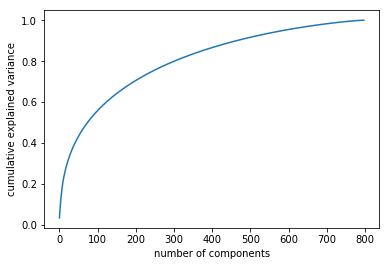

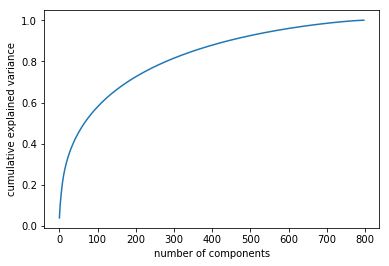

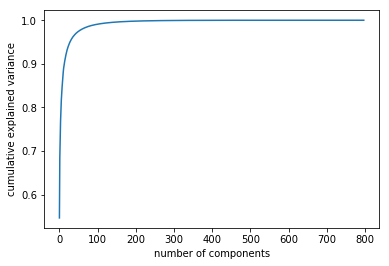

In [18]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions to start with, while VGGs had 25,088

In [19]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

### Cluster time

Let's write a couple of functions that would create and fit KMeans and Gaussian Mixture models.
While it can make sense to combine them in one function that returns both, I've seperated them so we can execute them seperately and make some observations without overloading the PC

In [20]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [21]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g
    

### Ask the clustering algo what it thinks is what

In [22]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 0.7219288349151611 seconds

VGG19
Training took 0.6002073287963867 seconds

ResNet50
Training took 0.5995471477508545 seconds


In [23]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)


GMM (PCA): 

VGG16
Training took 1.0057599544525146 seconds

VGG19
Training took 0.3446829319000244 seconds

ResNet50
Training took 0.3524143695831299 seconds


In [24]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)


KMeans: 

VGG16:
Training took 6.9162092208862305 seconds

VGG19:
Training took 7.194207668304443 seconds

ResNet50:
Training took 0.7229974269866943 seconds


#### Attempts to run the Gaussian Mixtue Model on the outputs without PCA always give an out of memory error. I am therefore unable to test these and conclude that they are impractical to use.

In [25]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

Remember that the clustering algorith does not detect which images are cats and which are dogs, it only groups images that look alike together and assigns them a number arbitrarily. 

We now need to count how many of each label are in  each cluster, this way we can take a look and if sufficient eperation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [26]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [27]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca, y_train)

In [28]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1,2,3
C1,7,167,24,0
C8,6,18,166,10
D19,163,25,9,3
D25,44,17,16,123


In [29]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2,3
C1,7,167,24,0
C8,6,18,166,10
D19,163,25,9,3
D25,44,17,16,123


In [30]:
print("GMM VGG16: ")
g_vgg16_cluster_count_pca

GMM VGG16: 


,0,1,2,3
C1,0,73,3,122
C8,0,175,19,6
D19,2,79,108,11
D25,1,43,147,9


We can see now that the Gaussian Model did not give a meaningful result. There are no clear dominant code for each cluster

In [31]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1,2,3
C1,105,57,12,24
C8,10,101,65,24
D19,4,50,0,146
D25,18,24,86,72


In [32]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1,2,3
C1,105,57,12,24
C8,10,101,65,24
D19,4,50,0,146
D25,18,24,86,72


In [33]:
print("GMM VGG19 (PCA): ")
g_vgg19_cluster_count_pca

GMM VGG19 (PCA): 


,0,1,2,3
C1,0,176,20,2
C8,0,132,68,0
D19,1,77,122,0
D25,0,34,166,0


In [34]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


,0,1,2,3
C1,96,11,86,5
C8,153,4,42,1
D19,17,94,66,23
D25,49,21,111,19


In [35]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


,0,1,2,3
C1,96,11,86,5
C8,153,4,42,1
D19,17,94,66,23
D25,49,21,111,19


In [36]:
print("GMM Resnet50 (PCA): ")
g_resnet50_cluster_count_pca

GMM Resnet50 (PCA): 


,0,1,2,3
C1,5,96,10,87
C8,1,153,4,42
D19,24,17,93,66
D25,21,52,19,108


We can see again, that models which took ResNet50 representations could not produce meaningful clusters. We will therefore stop pursuing them.

The models that made it through are:

1. KMeans VGG16
2. KMeans VGG16 PCA
3. KMeans VGG19
4. KMeans VGG19 PCA


Let's calculate some scores and see which one performs best.

### Cluster - Label assignment

In this part, we will manually look at the cluster count and give a best guess as to which cluster corresonds to which label. While normally each cluster will mostly consist of one label, it is not necessary the case if the clustering algorithm fails to seperate the images. It is therefore better to take stock here, and make sure that we are on the right path.

In [37]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["D19", "C1", "C8", "D25"]
vgg16_cluster_code_pca = ["D19", "C1", "C8", "D25"]

vgg19_cluster_code = ["C1", "C8", "D25", "D19"]
vgg19_cluster_code_pca = ["C1", "C8", "D25", "D19"]
# g_vgg19_cluster_code_pca = ["D25", "D19", "C8", "C1"]



### Replace the predicted clusters with their labels

In [38]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
# g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in g_vgg19_pred_pca]


### Metrics

Now that we have two arrays, one with the predicted labels and one with the true labels, we can go crazy with performance scores... or we can just compute the F1 score

In [39]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))
# print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.77355392   |   Accuracy: 0.77355392
KMeans VGG16 (PCA) 
	F1 Score: 0.77355392   |   Accuracy: 0.77355392

KMeans VGG19:  
	F1 Score: 0.54872423   |   Accuracy: 0.54872423
KMeans VGG19 (PCA):  
	F1 Score: 0.54872423   |   Accuracy: 0.54872423


### of note:

1. The scores (and cluster counts) of PCA and non-PCA transformed outputs are exactly the same. Since we fixed all random states, with the only difference being the inputs, we can see that PCA-transformed data adequately represents the original data while givig us faster training times and lower memory usage.

2. The clusters for PCA and non-PCA transformed data are exactly in the same order.

### Testing Time

Ultimately, for best results, you would want to do this whole excercise every time you change your data in order to find out which model is the best for this particular data.

We can now then do the same thing for our testing data, and see if it gives the best accuracy again. We can keep testing this for more and more breed pairs to gain more confidence that our model works.

This is in the end an unsupevised learning excercise, and we would not be able to check which model is best for a particular set of data if we do not have labels for them. The closer your images are to the dataset images, the better chance you have of getting a high accuracy.

In [68]:
# Let's put it all together

def all_covnet_transform(data):
    vgg16 = covnet_transform(vgg16_model, data)
    vgg19 = covnet_transform(vgg19_model, data)
    resnet50 = covnet_transform(resnet50_model, data)
    
    return vgg16, vgg19, resnet50


def image_load_to_cluster_count(codes):
    # Load images
    images, labels = load_images(codes)
    print(len(images), len(labels))
    show_random_images(images, labels)
    
    # Normalise images
    images, labels = normalise_images(images, labels)
    
    # Split data
    data, labels = shuffle_data(images, labels)
    
    # Get covnet outputs
    vgg16_output, vgg19_output, resnet50_output = all_covnet_transform(data)
    
    # Get PCA transformations
    vgg16_output_pca = create_fit_PCA(vgg16_output).transform(vgg16_output)
    vgg19_output_pca = create_fit_PCA(vgg19_output).transform(vgg19_output)
    resnet50_output_pca = create_fit_PCA(resnet50_output).transform(resnet50_output)
    
    # Cluster
    clusters = len(codes)
    
    K_vgg16_pred = create_train_kmeans(vgg16_output, clusters).predict(vgg16_output)
    K_vgg19_pred = create_train_kmeans(vgg19_output, clusters).predict(vgg19_output)
    K_resnet50_pred = create_train_kmeans(resnet50_output, clusters).predict(resnet50_output)
    K_vgg16_pred_pca = create_train_kmeans(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    K_vgg19_pred_pca = create_train_kmeans(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    K_resnet50_pred_pca = create_train_kmeans(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    G_vgg16_pred_pca = create_train_gmm(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    G_vgg19_pred_pca = create_train_gmm(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    G_resnet50_pred_pca = create_train_gmm(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    
    # Count
    vgg16_cluster_count = cluster_label_count(K_vgg16_pred, labels)
    vgg16_cluster_count_pca = cluster_label_count(K_vgg16_pred_pca, labels)

    # VGG19 KMeans
    vgg19_cluster_count = cluster_label_count(K_vgg19_pred, labels)
    vgg19_cluster_count_pca = cluster_label_count(K_vgg19_pred_pca, labels)

    # ResNet50 KMeans
    resnet_cluster_count = cluster_label_count(K_resnet50_pred, labels)
    resnet_cluster_count_pca = cluster_label_count(K_resnet50_pred_pca, labels)

    # GMM
    g_vgg16_cluster_count_pca = cluster_label_count(G_vgg16_pred_pca, labels)
    g_vgg19_cluster_count_pca = cluster_label_count(G_vgg19_pred_pca, labels)
    g_resnet50_cluster_count_pca = cluster_label_count(G_resnet50_pred_pca, labels)
    
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    print("\nKMeans VGG16 (PCA): ")
    print(vgg16_cluster_count_pca)
    print("\nGMM VGG16: ")
    print(g_vgg16_cluster_count_pca)
    print("\nKMeans VGG19: ")
    print(vgg19_cluster_count)
    print("\nKMeans VGG19 (PCA): ")
    print(vgg19_cluster_count_pca)
    print("GMM VGG19 (PCA): ")
    print(g_vgg19_cluster_count_pca)
    print("KMeans Resnet50: ")
    print(resnet_cluster_count)
    print("Kmeans Resnet50 (PCA): ")
    print(resnet_cluster_count_pca)
    print("GMM Resnet50 (PCA): ")
    print(g_resnet50_cluster_count_pca)
    
    return  K_vgg16_pred, K_vgg16_pred_pca, K_vgg19_pred, K_vgg19_pred_pca, G_vgg19_pred_pca, images, labels
    
    

599 599
2 random images for code D9


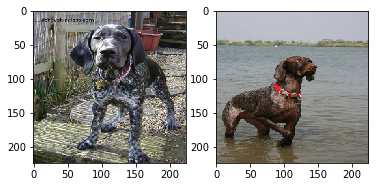

2 random images for code D21


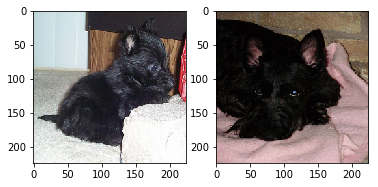

2 random images for code D11


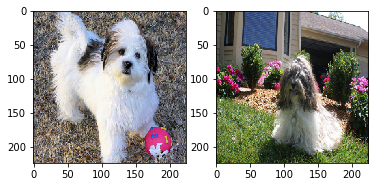

Training took 4.604398488998413 seconds
Training took 4.304678201675415 seconds
Training took 0.7277133464813232 seconds
Training took 0.525261402130127 seconds
Training took 0.5171723365783691 seconds
Training took 0.4291813373565674 seconds
Training took 0.12474989891052246 seconds
Training took 0.12438201904296875 seconds
Training took 0.11364531517028809 seconds
KMeans VGG16: 
       0    1    2
D11  158   36    6
D21   43  154    2
D9    11   12  177

KMeans VGG16 (PCA): 
       0    1    2
D11  158   36    6
D21   43  154    2
D9    11   12  177

GMM VGG16: 
       0    1    2
D11  146   14   40
D21   47   24  128
D9    33  115   52

KMeans VGG19: 
       0   1    2
D11  134  12   54
D21   61  31  107
D9    18  86   96

KMeans VGG19 (PCA): 
       0   1    2
D11  134  12   54
D21   61  31  107
D9    18  86   96
GMM VGG19 (PCA): 
       0    1    2
D11   19   50  131
D21   34  106   59
D9   102   86   12
KMeans Resnet50: 
       0   1   2
D11  100  15  85
D21   93  18  88
D9    65

In [69]:
codes = ["D9", "D21", "D11"]
outputs = image_load_to_cluster_count(codes)

In [71]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["D11", "D21", "D9"]
vgg16_cluster_code_pca = ["D11", "D21", "D9"]

vgg19_cluster_code = ["D11", "D9", "D21"]
vgg19_cluster_code_pca = ["D11", "D9", "D21"]
g_vgg19_cluster_code_pca = ["D9", "D21", "D11"]


vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in outputs[1]]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in outputs[3]]
g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in outputs[4]]

print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))
print("GMM VGG19 (PCA)", print_scores(outputs[-1], g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.81818354   |   Accuracy: 0.81818354
KMeans VGG16 (PCA) 
	F1 Score: 0.81818354   |   Accuracy: 0.81818354

KMeans VGG19:  
	F1 Score: 0.54700167   |   Accuracy: 0.54700167
KMeans VGG19 (PCA):  
	F1 Score: 0.54700167   |   Accuracy: 0.54700167
GMM VGG19 (PCA) 
	F1 Score: 0.56903827   |   Accuracy: 0.56903827


Looks like VGG16 is doing the best again! Let's test one more time...

400 400
2 random images for code C12


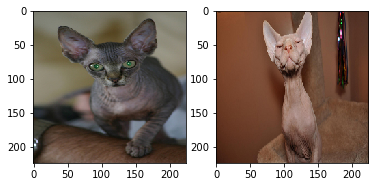

2 random images for code C8


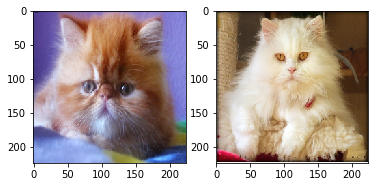

Training took 2.0604324340820312 seconds
Training took 2.1226677894592285 seconds
Training took 0.5574600696563721 seconds
Training took 0.4646637439727783 seconds
Training took 0.45760464668273926 seconds
Training took 0.44739389419555664 seconds
Training took 0.027288436889648438 seconds
Training took 0.02394580841064453 seconds
Training took 0.022562503814697266 seconds
KMeans VGG16: 
       0    1
C12    5  195
C8   195    5

KMeans VGG16 (PCA): 
       0    1
C12    5  195
C8   195    5

GMM VGG16: 
       0    1
C12    5  195
C8   194    6

KMeans VGG19: 
       0    1
C12  185   15
C8     9  191

KMeans VGG19 (PCA): 
       0    1
C12  185   15
C8     9  191
GMM VGG19 (PCA): 
     0    1
C12  1  199
C8   1  199
KMeans Resnet50: 
      0    1
C12  99  101
C8   20  180
Kmeans Resnet50 (PCA): 
      0    1
C12  99  101
C8   20  180
GMM Resnet50 (PCA): 
      0    1
C12  99  101
C8   20  180


In [78]:
codes = ["C12", "C8"]
outputs = image_load_to_cluster_count(codes)

By now we can see that ResNet is performing terribly in all our tests. We can also see that PCA and non-PCA are the same, so we can just use the same cluster/code combinations for them, and that GMM has consistently performed same as or much worse than KMeans.

The two we will consider now are Kmeans VGG16 and VGG19

In [79]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["C8", "C12"]
vgg19_cluster_code = ["C12","C8"]

In [82]:
# Let's define a function for scores

def scoring(vgg16_cluster_code, vgg19_cluster_code, outputs):
    vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
    vgg16_pred_codes_pca = [vgg16_cluster_code[x] for x in outputs[1]]
    vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
    vgg19_pred_codes_pca = [vgg19_cluster_code[x] for x in outputs[3]]

    print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
    print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

    print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
    print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))

In [83]:
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.97500000   |   Accuracy: 0.97500000
KMeans VGG16 (PCA) 
	F1 Score: 0.97500000   |   Accuracy: 0.97500000

KMeans VGG19:  
	F1 Score: 0.93998650   |   Accuracy: 0.93998650
KMeans VGG19 (PCA):  
	F1 Score: 0.93998650   |   Accuracy: 0.93998650


VGG16 wins again!

Now let's try a cat and dog pair for our final test

400 400
2 random images for code D1


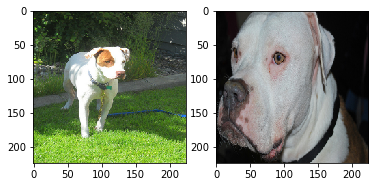

2 random images for code C7


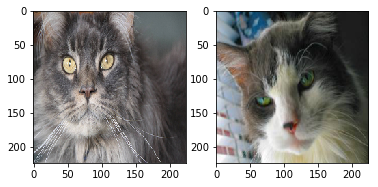

Training took 2.5923378467559814 seconds
Training took 2.034688711166382 seconds
Training took 0.4773135185241699 seconds
Training took 0.5953502655029297 seconds
Training took 0.565504789352417 seconds
Training took 0.4808497428894043 seconds
Training took 0.034923553466796875 seconds
Training took 0.024074554443359375 seconds
Training took 0.025286436080932617 seconds
KMeans VGG16: 
      0    1
C7  196    4
D1    5  195

KMeans VGG16 (PCA): 
      0    1
C7  196    4
D1    5  195

GMM VGG16: 
      0    1
C7    4  196
D1  195    5

KMeans VGG19: 
      0    1
C7   57  143
D1  200    0

KMeans VGG19 (PCA): 
      0    1
C7   57  143
D1  200    0
GMM VGG19 (PCA): 
     0    1
C7  15  185
D1  36  164
KMeans Resnet50: 
      0    1
C7   41  159
D1  116   84
Kmeans Resnet50 (PCA): 
      0    1
C7   41  159
D1  116   84
GMM Resnet50 (PCA): 
      0    1
C7   39  161
D1  111   89


In [84]:
codes = ["D1", "C7"]
outputs = image_load_to_cluster_count(codes)

In [85]:
vgg16_cluster_code = ["C7", "D1"]
vgg19_cluster_code = ["D1","C7"]
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.97749986   |   Accuracy: 0.97749986
KMeans VGG16 (PCA) 
	F1 Score: 0.97749986   |   Accuracy: 0.97749986

KMeans VGG19:  
	F1 Score: 0.85454638   |   Accuracy: 0.85454638
KMeans VGG19 (PCA):  
	F1 Score: 0.85454638   |   Accuracy: 0.85454638


 ## It is possible to cluster images of different pet breeds 